## Indice des Sols Nus (BSI)

### Description de l’indicateur

Le **BSI (Bare Soil Index)** est un indice spectral de télédétection utilisé
pour **identifier et cartographier les sols nus ou faiblement végétalisés**.
Il est particulièrement pertinent pour l’analyse de la dégradation des sols,
la désertification et la dynamique d’occupation du sol dans les régions arides
et semi-arides.

Le BSI repose sur les **différences de comportement spectral entre les sols
nus, la végétation et l’eau**. Les sols nus présentent généralement une
réflectance élevée dans le **rouge (Red)** et le **moyen infrarouge (SWIR)**,
tandis que la végétation réfléchit davantage le **proche infrarouge (NIR)** et
absorbe le rouge. L’eau, quant à elle, absorbe fortement dans le NIR et le SWIR.

Ainsi, le BSI permet de **renforcer le signal des sols nus** tout en atténuant
celui de la végétation et des surfaces en eau.

Les valeurs du BSI sont comprises entre **−1 et +1** :

- **BSI négatif** : surfaces couvertes par la végétation ou par l’eau ;
- **BSI proche de 0** : zones de transition, sols partiellement couverts ;
- **BSI positif élevé (> 0)** : sols nus, surfaces dégradées ou zones
  faiblement végétalisées.

Le BSI est couramment utilisé pour :
- la cartographie des sols nus et des zones dégradées ;
- l’étude de la désertification et de l’érosion des sols ;
- l’analyse de la dynamique saisonnière de la couverture du sol ;
- les études environnementales et agroécologiques.

---

### Méthodologie de calcul

Le BSI est calculé à partir des images multispectrales **Sentinel-2**, en
combinant quatre bandes spectrales :

- **B4 (Rouge – Red)** : bande centrée autour de **665 nm**, sensible à la
  réflectance des sols nus ;
- **B8 (Proche infrarouge – NIR)** : bande centrée autour de **842 nm**, fortement
  réfléchie par la végétation ;
- **B11 (Moyen infrarouge – SWIR)** : bande centrée autour de **1610 nm**, très
  sensible à l’humidité du sol et aux surfaces minérales ;
- **B2 (Bleu – Blue)** : bande centrée autour de **490 nm**, utilisée pour
  améliorer la discrimination entre sols nus et surfaces artificialisées.

La formule du BSI est définie comme suit :

$$
BSI = \frac{(SWIR + Red) - (NIR + Blue)}{(SWIR + Red) + (NIR + Blue)}
$$

où :
- $SWIR$ représente la réflectance de la bande **B11** ;
- $Red$ représente la réflectance de la bande **B4** ;
- $NIR$ représente la réflectance de la bande **B8** ;
- $Blue$ représente la réflectance de la bande **B2**.

Cette formulation permet de **maximiser le contraste des sols nus** tout en
réduisant l’influence de la végétation et de l’eau.

---


BSI min : -0.15641801
BSI max : 0.37305838


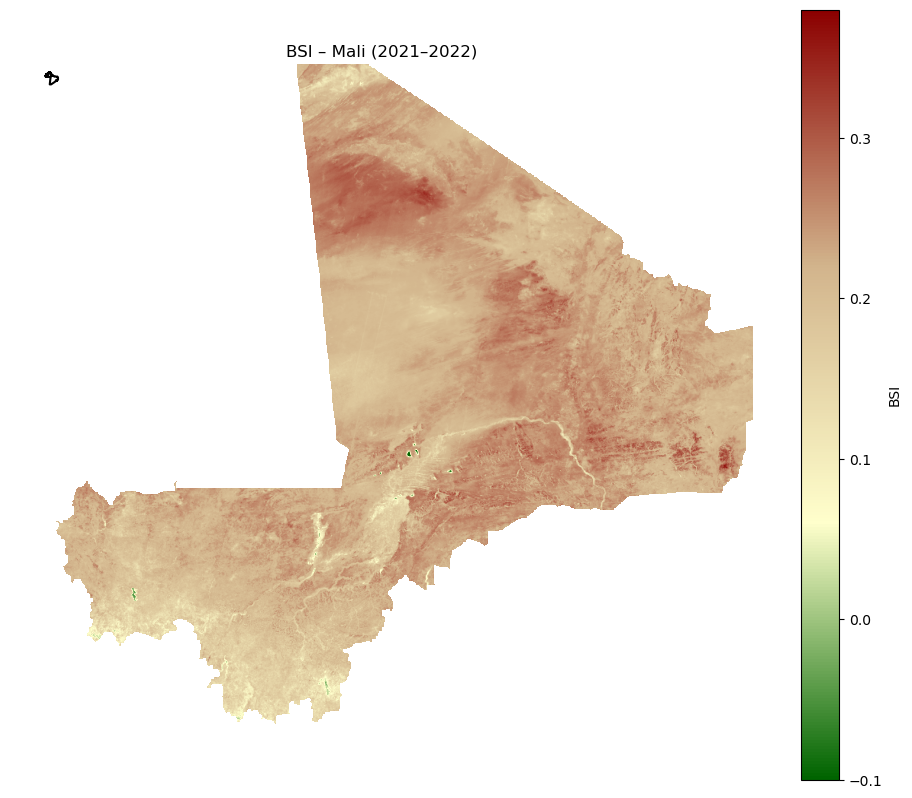

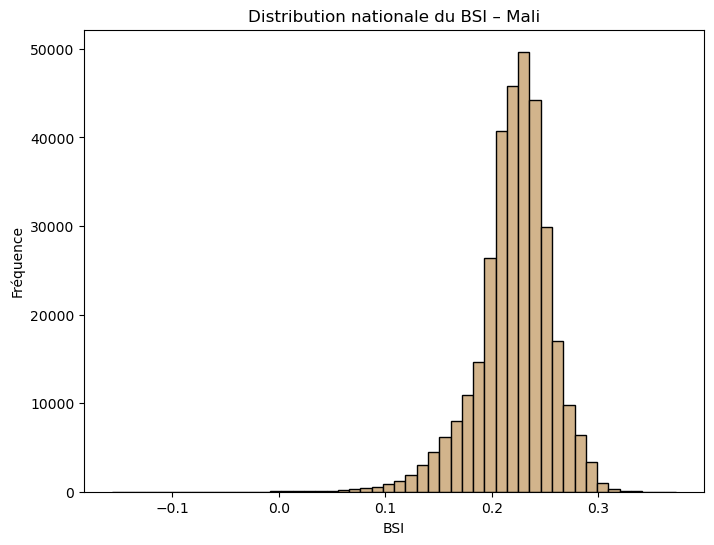

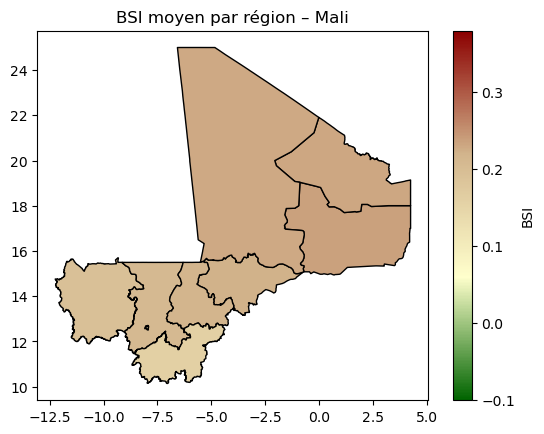

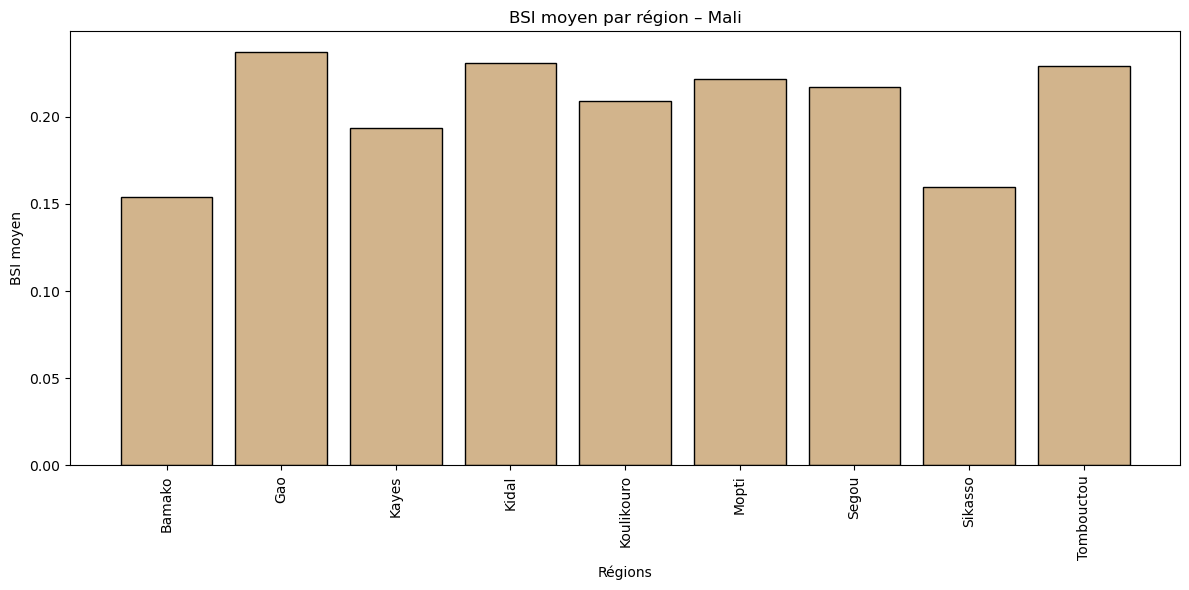

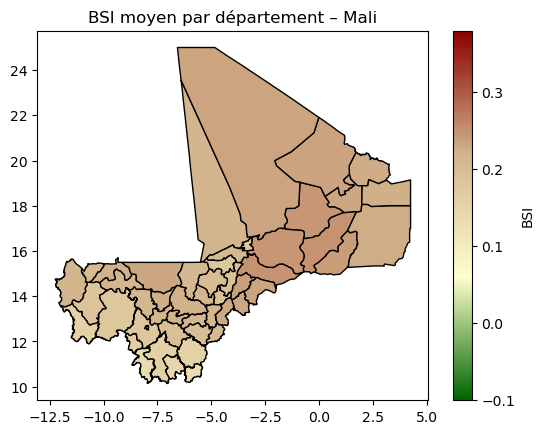

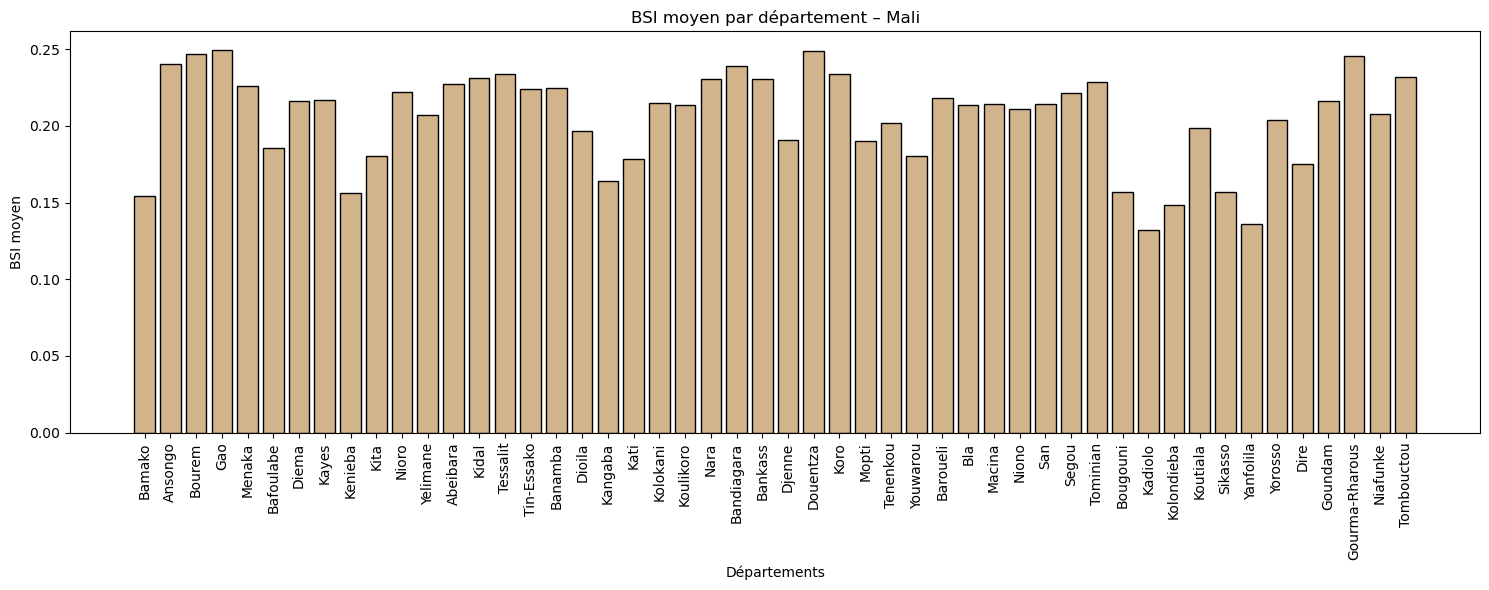

Table départementale BSI enregistrée dans outputs/BSI/


In [2]:
# ======================================================
# BSI.ipynb – Calcul et analyse exploratoire du BSI
# ======================================================

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ======================================================
# 1️⃣ Chemins
# ======================================================
BASE_DIR = os.getcwd()  # tp/scripts
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "outputs", "BSI")
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_blue = os.path.join(DATA_DIR, "Mali_2022_B2_100m.tif")   # BLUE
path_red  = os.path.join(DATA_DIR, "Mali_2022_B4_100m.tif")   # RED
path_nir  = os.path.join(DATA_DIR, "Mali_2022_B8_100m.tif")   # NIR
path_swir = os.path.join(DATA_DIR, "Mali_2022_B11_100m.tif")  # SWIR

factor = 20  

# ======================================================
# 2️⃣ Lecture + rééchantillonnage 
# ======================================================
def read_resample(path, factor):
    with rasterio.open(path) as src:
        new_width  = src.width // factor
        new_height = src.height // factor

        data = src.read(
            1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        ).astype("float32")

        transform = src.transform * src.transform.scale(
            src.width / new_width,
            src.height / new_height
        )

        profile = src.profile.copy()
        profile.update({
            "height": new_height,
            "width": new_width,
            "transform": transform
        })

    return data, profile


blue, profile = read_resample(path_blue, factor)
red,  _       = read_resample(path_red, factor)
nir,  _       = read_resample(path_nir, factor)
swir, _       = read_resample(path_swir, factor)

# ======================================================
# 3️⃣ Calcul BSI
# ======================================================
np.seterr(divide="ignore", invalid="ignore")

bsi = ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))
bsi = np.where((bsi < -1) | (bsi > 1), np.nan, bsi)

print("BSI min :", np.nanmin(bsi))
print("BSI max :", np.nanmax(bsi))

# ======================================================
# 4️⃣ Palette continue BSI
# (végétation → sol nu → zones bâties)
# ======================================================
bsi_cmap = LinearSegmentedColormap.from_list(
    "bsi_cmap",
    [
        "#006400",  # vert foncé : végétation
        "#ffffcc",  # jaune clair : sols nus
        "#d2b48c",  # marron clair : zones peu urbanisées
        "#8b0000"   # rouge foncé : zones fortement urbanisées
    ]
)

bsi_norm = Normalize(vmin=-0.1, vmax=0.38)

# ======================================================
# 5️⃣ Analyse nationale
# ======================================================
mali = gpd.read_file(os.path.join(DATA_DIR, "mli_admin0.shp"))
mali = mali.to_crs(profile["crs"])

plt.figure(figsize=(12, 10))
plt.imshow(bsi, cmap=bsi_cmap, norm=bsi_norm)
mali.boundary.plot(ax=plt.gca(), edgecolor="black", linewidth=1.5)
plt.colorbar(label="BSI")
plt.title("BSI – Mali (2021–2022)")
plt.axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_nationale.png"), dpi=300)
plt.show()

# Histogramme national
plt.figure(figsize=(8, 6))
plt.hist(bsi[~np.isnan(bsi)], bins=50, color="#d2b48c", edgecolor="black")
plt.title("Distribution nationale du BSI – Mali")
plt.xlabel("BSI")
plt.ylabel("Fréquence")
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_histogramme_nationale.png"), dpi=300)
plt.show()

# ======================================================
# 6️⃣ Analyse régionale (Admin1)
# ======================================================
regions = gpd.read_file(os.path.join(DATA_DIR, "mli_admin1.shp"))
regions = regions.to_crs(profile["crs"])

regional_bsi = []

for _, row in regions.iterrows():
    geom = [row.geometry]

    with rasterio.open(path_blue) as src:
        blue_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_red) as src:
        red_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_nir) as src:
        nir_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_c, _ = mask(src, geom, crop=True)

    blue_c = blue_c[0].astype("float32")
    red_c  = red_c[0].astype("float32")
    nir_c  = nir_c[0].astype("float32")
    swir_c = swir_c[0].astype("float32")

    bsi_c = ((swir_c + red_c) - (nir_c + blue_c)) / ((swir_c + red_c) + (nir_c + blue_c))
    bsi_c = np.where((bsi_c < -1) | (bsi_c > 1), np.nan, bsi_c)

    regional_bsi.append(np.nanmean(bsi_c))

regions["BSI"] = regional_bsi

# Carte régionale
regions.plot(column="BSI", cmap=bsi_cmap, norm=bsi_norm,
             edgecolor="black", legend=True,
             legend_kwds={"label": "BSI"})
plt.title("BSI moyen par région – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_regionale.png"), dpi=300)
plt.show()

# Barplot régional
plt.figure(figsize=(12, 6))
plt.bar(regions["shapeName"], regions["BSI"], color="#d2b48c", edgecolor="black")
plt.xticks(rotation=90)
plt.title("BSI moyen par région – Mali")
plt.xlabel("Régions")
plt.ylabel("BSI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_bar_regions.png"), dpi=300)
plt.show()
# ======================================================
# 7️⃣ Analyse départementale (Admin2)
# ======================================================
departements = gpd.read_file(os.path.join(DATA_DIR, "mli_admin2.shp"))
departements = departements.to_crs(profile["crs"])

dept_bsi = []

for _, row in departements.iterrows():
    geom = [row.geometry]

    with rasterio.open(path_blue) as src:
        blue_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_red) as src:
        red_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_nir) as src:
        nir_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_c, _ = mask(src, geom, crop=True)

    blue_c = blue_c[0].astype("float32")
    red_c  = red_c[0].astype("float32")
    nir_c  = nir_c[0].astype("float32")
    swir_c = swir_c[0].astype("float32")

    bsi_c = ((swir_c + red_c) - (nir_c + blue_c)) / ((swir_c + red_c) + (nir_c + blue_c))
    bsi_c = np.where((bsi_c < -1) | (bsi_c > 1), np.nan, bsi_c)

    dept_bsi.append(np.nanmean(bsi_c))

departements["BSI"] = dept_bsi

# Carte départementale
departements.plot(column="BSI", cmap=bsi_cmap, norm=bsi_norm,
                  edgecolor="black", legend=True,
                  legend_kwds={"label": "BSI"})
plt.title("BSI moyen par département – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_departementale.png"), dpi=300)
plt.show()

# Barplot départemental
plt.figure(figsize=(15, 6))
plt.bar(departements["shapeName"], departements["BSI"], color="#d2b48c", edgecolor="black")
plt.xticks(rotation=90)
plt.title("BSI moyen par département – Mali")
plt.xlabel("Départements")
plt.ylabel("BSI moyen")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "BSI_bar_departements.png"), dpi=300)
plt.show()

# Enregistrement CSV
bsi_table = departements[["shapeName", "BSI"]].copy()
bsi_table.to_csv(os.path.join(OUTPUT_DIR, "BSI_departements.csv"), index=False)
print("Table départementale BSI enregistrée dans outputs/BSI/")
